# Computer Vision - P3

## Delivery

Up to **1 point out of 10** will be penalized if the following requirements are not fulfilled:

- Implemented code should be commented.

- The questions introduced in the exercises must be answered.

- Add title to the figures to explain what is displayed.

- Comments need to be in **English**.

- The deliverable of both parts must be a file named **P3_Student1_Student2.zip** that includes:
    - The notebook P3_Student1_Student2.ipynb completed with the solutions to the exercises and their corresponding comments.
    - All the images used in this notebook.

**Deadline (Campus Virtual): November 1st, 23:00 h** 

==============================================================================================
## Practicum 3: Image and Video Segmentation

==============================================================================================

The main topics of Laboratory 3 are:

3.1. Segmentation of video shots with static scenes.

3.2. Background subtraction.

3.3. Segmentation of images.

The following chapters of the book “Computer Vision: Algorithms and Applicatons” from Richard Szeliski have further information about the topic:

* Chapter 4: Computer Vision: Algorithms and Applications.

* Chapter 5: Segmentation.



## Video segmentation

Given the video stored in ‘Barcelona-sequence’, which contains images acquired by a static camera, we ask you to:
- Find the temporal segments of the video (shots). Where the scene change? (Section 3.1)
- Extract the background images and thus, remove all the "artifacts" considered as foreground related to movement. (Section 3.2)




<img src="images/screenshot.png" width=600>

## 3.1 Segmentation of video shots

Read and visualize the sequence of images "images/Barcelona-sequence".

**Hint:** In order to read a collection of images, we wil use the function [animation.FuncAnimation](https://matplotlib.org/2.0.0/api/_as_gen/matplotlib.animation.FuncAnimation.html). Observe in the following Example, how FuncAnimation is used to read and visualize a sequence of frames. Explore the parameters of animation.FuncAnimation().

In [1]:
import numpy as np
import skimage
from skimage import io
import matplotlib.pyplot as plt
import matplotlib.animation as animation

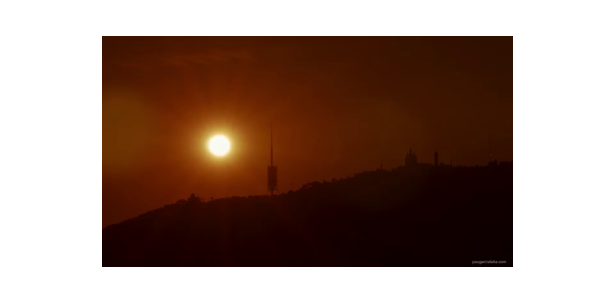

In [2]:
# In VSCode nbagg doesn't work, we'll use widget
%matplotlib widget

# Reading a sequence of images from a folder
ic = io.ImageCollection('images/Barcelona-sequence/*.png')

fig = plt.figure(figsize=(6, 3))        # Create figure
plt.axis('off')
im = plt.imshow(ic[0], animated=True)   # Visualize the first image

def run(i):                 # Updating the frame visualization
    im.set_array(ic[i])     # Changing the content of the canvas
    return im,              # to return a tuple!

# The code execution is slower than 1ms, so if interval=1 then the fps
# are the speed to compute each iteration, which varies notably.
# Because of this we've fixed 24 fps (with interval 1 / 24 * 1000 ms)
INTERVAL_24_FPS = 42
ani = animation.FuncAnimation(fig, run, interval=INTERVAL_24_FPS, blit=True, frames=len(ic), repeat= False)
plt.show()

a) Find where a shot (scene) finishes and the following starts (the shot boundaries). To achieve this goal, we are going to compute the difference between the histograms of consecutive frames. The proposed solution required:

- Compute the histogram for each RGB channel

- The 'total' histogram of the image is computed as the sum of the three histograms

- Compute the mean of the difference (in absolute value) between the histograms of two consecutive frames

Those differences with largest values corresponds to the transitions between shots. 

Therefore, **we need to create a funtion which return an array with the differences between histograms. We will plot the resulting array in order to localice the maximum values as well as a suitable threshold to define localize the transitions.**

<img src="images/histogramshot.png" width=600>
<img src="images/difference_histograms.png">

To solve this exercise, you need to create a **temporal plot** showing a frame by frame difference measure to be defined by you, being applicable to distinguish the shots. Define a criterion to detect the boundaries of the shots and visualize it in a static plot.

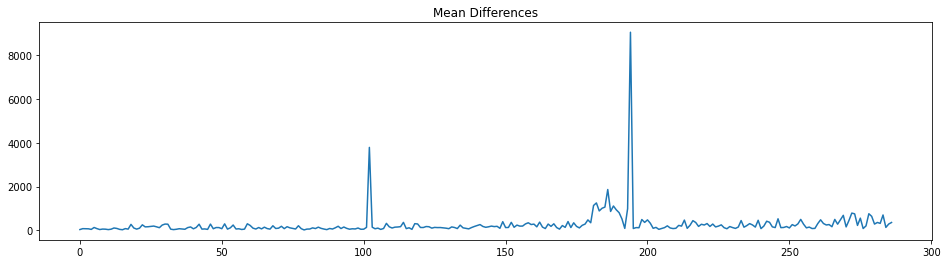

In [3]:
from skimage import img_as_float
from skimage.exposure import histogram
import numpy as np

%matplotlib inline

'''
We create the three histograms and concatenate them in every iteration. In every iteration 
(except the first one) we store the histogram to use it in the next iteration and substract
it from the histogram calculated in that one. Of course, after the substraction we compute the
absolute value and then store the mean in an array that will contain all the means. After that,
we plot in a line said array.
'''

# We make the relativeness smoother so a change in a small
# number of pixels doesn't heavily alter the histogram
def relative_histogram(image, nbins):
    flat, extreme = image.flatten(), image.size * 1//512
    lower = np.mean(flat[np.argpartition(flat, extreme)[:extreme]])
    upper = np.mean(flat[np.argpartition(flat, -extreme)[-extreme:]])
    return histogram(np.clip(image, lower, upper), nbins=nbins)

def get_mean_differences(ic, nbins=32):
    mean_differences = []
    for i, frame in enumerate(ic):
        # We concatenate the colors so we don't lose information
        new_frequencies = np.concatenate([relative_histogram(frame[:, :, i], nbins)[0] for i in range(3)])
        if i > 0:
            mean_differences.append(np.mean(np.abs(new_frequencies - prev_frequencies)))
        prev_frequencies = new_frequencies
    return mean_differences

'''
The image collection is a fragment from a video, and it turns out
it is cut at an unfortunate moment, making the last 2 frames from
a different scene, but it is weird to consider two frames as a scene.
This is very inconvenient for the general case because we don't want
to lose image frames when splitting the video, so we normally would just
not make the splits if they cause a very short shot.
'''
float_ic = img_as_float(ic[:-2])
mean_differences = get_mean_differences(float_ic)

plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(mean_differences)), mean_differences)
plt.title("Mean Differences")
plt.show()

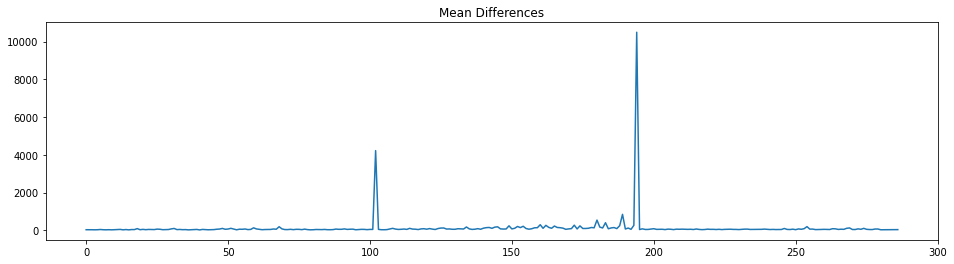

In [68]:
from skimage.exposure import histogram
from skimage import img_as_float

%matplotlib inline

'''
We create the three histograms and concatenate them in every iteration. In every iteration 
(except the first one) we store the histogram to use it in the next iteration and substract
it from the histogram calculated in that one. Of course, after the substraction we compute the
absolute value and then store the mean in an array that will contain all the means. After that,
we plot in a line said array.
'''



def get_mean_differences(ic, nbins=32):
    mean_differences = []
    for i, frame in enumerate(ic):
        # We concatenate the colors so we don't lose information
        new_frequencies = np.concatenate([np.histogram(frame[:, :, i], nbins, range=(0, 1))[0] for i in range(3)])
        if i > 0:
            mean_differences.append(np.mean(np.abs(new_frequencies - prev_frequencies)))
        prev_frequencies = new_frequencies
    return mean_differences


'''
The image collection is a fragment from a video, and it turns out
it is cut at an unfortunate moment, making the last 2 frames from
a different scene, but it is weird to consider two frames as a scene.
This is very inconvenient for our code so we will just delete these
two last
'''
float_ic = img_as_float(ic[:-2])
mean_differences = get_mean_differences(float_ic)

plt.figure(figsize=(16, 4))
plt.plot(np.arange(len(mean_differences)), mean_differences)
plt.title("Mean Differences")
plt.show()

b) Additionally, create an interactive plot executing the following code in "Example A". Substitute the bottom plot with the temporal plot showing the differences between the consecutive frames. 

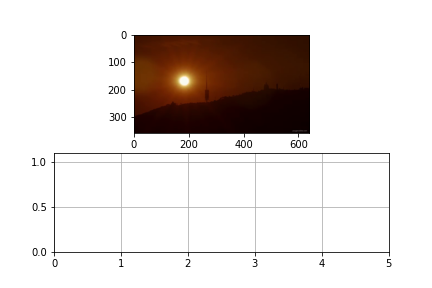

In [7]:
%matplotlib widget

'''
We will use the example and modify it. We have taken the freedom to optimize the code
by removing redundant calculations. We have also changed de Example A code to use the
array we calculated in a). We will use the function enumerate. It, conveniently, returns
a generator where the values are (x, y) where x is the position of the value y in the 
mean differences array
'''

def data_gen():
    return enumerate(mean_differences)

# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(2,1)

im = ax1.imshow(ic[0], animated=True)   # Visualize the first image

# intialize a line object on the second axes for plotting
line, = ax2.plot([], [], lw=2, color='r')

ax2.set_ylim(0, 1.1)
ax2.set_xlim(0, 5)
ax2.grid()

# initialize the data arrays 
xdata, ydata = [], []
def run(data):
    # update the data plot
    t, y = data
    xdata.append(t) # time = x axis
    ydata.append(y) # y axis

    # If not it was extremely slow (it painted everything again every iteration!!!!!)
    im.set_array(ic[t])
          
    # Plot sin in bottom row
    xmin, xmax = ax2.get_xlim()
    ymin, ymax = ax2.get_ylim()
    
    if t >= xmax:
        ax2.set_xlim(xmin, 2*xmax)
        ax2.figure.canvas.draw()
    
    if y >= ymax:
        ax2.set_ylim(ymin, 2*ymax)
        ax2.figure.canvas.draw()
            
    # update the data of both line objects
    line.set_data(xdata, ydata)

    return line, im

ani = animation.FuncAnimation(fig, run, data_gen, blit=True, interval=INTERVAL_24_FPS, repeat=False)
plt.show()

c) Show the initial and final images of each shot extracted as follows:

<img src="images_for_notebook/result_shot_detection.png">


Use the previous plot to define the proper threshold value over the differences of histograms. Use the threshold to localize indexes of the array returned by the function proposed in the previous question and, therefore, localize the initial and final frames for each shot.


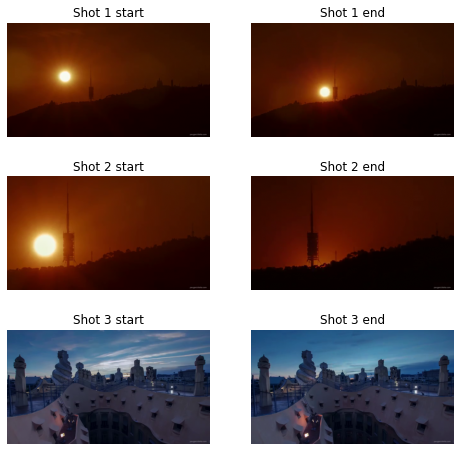

In [6]:
%matplotlib inline

'''
We just iterate through the mean differences array and when the value is above a defined
threshold (that we will explain in d)), we store the image of the current iteration index
and the NEXT one. Why the next one? The array of mean_differences is one element smaller
than the images one, so when we iterate over the small one, the other one will be "one
index behind". After that we also add the first and last images, as they represent the
first frame from the first shot and the last frame from the last one.

We finish by plotting them in pairs, knowing that we have created the images matrix in
a convenient order.
'''

threshold = 2500

images = [float_ic[0]]
separations = [0]
for i in range(len(mean_differences)):
    if mean_differences[i] > threshold:
        images.append(float_ic[i])
        images.append(float_ic[i+1])
        separations.append(i+1)
images.append(float_ic[-1])
separations.append(len(float_ic))

fig, axs = plt.subplots(nrows=len(images)//2, ncols=2, figsize=(8, 8))
for i in range(len(images)//2):
    axs[i, 0].imshow(images[2*i])
    axs[i, 1].imshow(images[2*i + 1])

    axs[i, 0].axis('off')
    axs[i, 1].axis('off')

    axs[i, 0].title.set_text(f'Shot {i+1} start')
    axs[i, 1].title.set_text(f'Shot {i+1} end')

plt.show()

d) Which measure have you used in order to visually distinguish the shots in a plot? Explain your solution.

**For the time being, we have basically estimated what are the shot changes based on the tallest peaks in the graph of the mean differences.**

**However, we have thought of a way to generalize/automatize it by comparing the values, for example, by quantiles (this of course, is a little
more inneficient but does not require human action and is automatic).**

e) Would your video segmentation strategy be able to separate and track objects? Argue your answer.

<span style="color:red"> It's not pixel by pixel!!!</span>

**No, our segmentation strategy does a pixel by pixel comparison. Though it is true that a change in an object in the image might cause a "peak" in the differences graph, other types of changes between frames would have the same effect (for example, a reduction of the frame brightness). For similar reasons, it is not capable of tracking objects, the best example is the sun setting, we don't really get any information in the histograms about the sun moving in each frame, but we do get it when the camera zooms in, this is a big counter example to the supposition of this being a good strategy to separate/track objects.**

f) Would your video segmentation strategy be able to capture continuous transition? Argue your answer.

**No, it is actually far from it. If the video was made of continuous transitions the difference between frames would be similar in every transition. This would result in a graph where it is impossible to distinguish relevant peaks.**

## 3.2 Background subtraction

Apply the background subtraction algorithm (check theory material).

<img src="images/screenshot2.png" width=500>

a) Visualize the following images for each different scene of the video:

    1) an image belonging to the shot
    2) the background image, and
    3) the foreground.
    
**Hint**: You can construct a mask obtained from the original image and the background in order to know which parts of the image form part from the foreground and recover from the original image just the foreground regions.

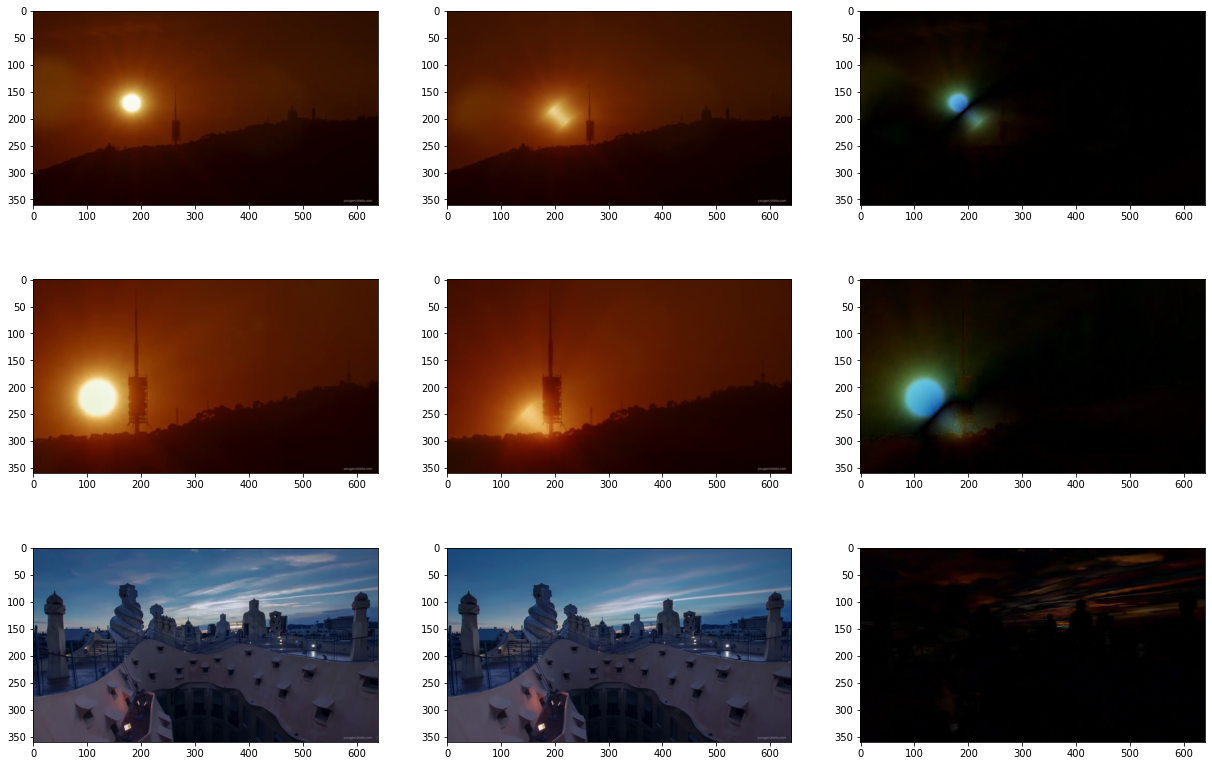

In [9]:
%matplotlib inline

'''
To do this we have modified a little bit the previous exercice's code. Basically,
we have created an array to keep track of the indexes of the ImageCollection where
a shot starts and ends. With this, we can store in a new array the separate scenes
from the video. After that, we apply the median to each scene to get the background
and we substract it from the original to get the foreground. After that we just show
every trio of images (we have used the first frame of the shot) from every shot.
'''

scenes = []
for i in range(len(separations)-1):
    scenes.append(np.array(float_ic[separations[i]:separations[i+1]]))

fig, axs = plt.subplots(len(scenes), 3, figsize=(21, 14))
for i in range(len(scenes)):
    background = np.median(scenes[i], axis=0)
    foreground = np.abs(scenes[i][0] - background)
    axs[i, 0].imshow(scenes[i][0])
    axs[i, 1].imshow(background)
    axs[i, 2].imshow(foreground)
plt.show()

b) What do the static background images represent? 

**They represent the parts of the image that do not change over the course of the scene. By applying the median, all the pixels 
that stay the same over the course of the scene will have practically the same value after applying the median. The non-static
elements, however will have its pixel values changed and sort of merged with its surrounding pixel colors. We can use our results
to somewhat exemplify what happens and explain them. In the first two scenes. In the two first scenes, for instance, we can see
that the sun, even though it's non-static, does not completely merge with the sky color. This is because during the sun's movement
there are some positions where there is always "sun" in it (i.e at the start there is the bottom-right corner of the sun and towards
the end there is the top-left. A similar thing happens with the clouds, but this is more subtle and more related to the fact that
some clouds move very slowly or don't move at all.**

c) What happens if the shots are not correctly extracted? And, what happens if you find too many shots in the video? 

**I DON'T UNDERSTAND THE QUESTION**

d) What happens if you subtract the background image from the original one?

**As we can see in our results, what happens is that the image will be completely black, except
for the elements of the original scene that are not static (i.e. sun, clouds). Note that in 
the sun scenes we also see other objects that are actually static. This is because the light
that the sun generates moves with it, changing the brightness in the sky and its surrounding
objects, this also explain why they are, in fact, more subtle than the sun itself.**

In [ ]:
ic = io.ImageCollection('images/Spy_x_Family/*.png')

e) In which situations does the algorithm work and in which it does not? Do you see any additional application for this algorithm?

**In general, this algorith works for scenes where the background does not change too much, and the non-static elements are clearly
distinguishable from the background (majorly because they are rather small or tend to appear in similar positions over the course of the scene.
If there was a changing background (be it brightness or too many non-static elements appearing inconsistantly in different parts of the frames
this algorith wouldn't be as effective, as the median would result in a weird merging where it is hard to distinguish between background and
elements.**

f) **[OPTIONAL]**
- Apply the algorithm to some other video that you found.

In [18]:
# Your solution here


## 3.3 Segmentation of images

Apply the image segmentation methods (Felzenswhalbs, Slic and Quickshift) based on the clustering of points corresponding to the pixels but in the feature space RGB-XY space.

**Hint**: 
- Different image segmentation commands can be found in skimage.segmentation.
- Use the function segmentation.mark_boundaries for seeing the boundaries of the segments.
- Use the inline pluggin to visualize images (%matplotlib inline).

<img src="images/image_Segmentation.png" width=600>

### Felzenszwalb's efficient graph based segmentation

a) Read 'rocki.jpeg' image from the folder 'images' and segment it using the Felzenszwalbs's method. Comment the result.


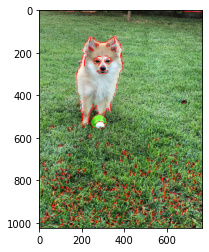

In [46]:
from skimage.segmentation import felzenszwalb, mark_boundaries

rocki = io.imread('images/rocki.jpeg')

felzen_rocki = felzenszwalb(rocki, scale=500, sigma=2, min_size=100)
plt.imshow(mark_boundaries(rocki, felzen_rocki, color=(1,0,0)))
plt.show()

b) Test and explore different parameters in order to obtain a good image segmentation up to you. 
Answer the following qüestions:
- Is it critical to convert the image in grayscale in order to do the image segmentation?
- Is it critical to convert the image in float in order to do the image segmentation?
- Which are the optimal values according to your subjective perception?
- How does each parameter behave?

Note: You can reduce the size of the image in order to accelerate the running. Does the image reduction affect the optimal values? 



In [20]:
# Your solution here

c) Comment the definition of the algorithm (use approximately 3 lines at most), its advantages and disadvantages.

In [21]:
# Your solution here

### SLIC - K-Means based image segmentation
d) Segment the same image using the SLIC image segmentation algorithm using the parameters by default. 

In [22]:
# Your solution here

e) Explore what are the parameters of the slic function. Test different values for these parameters in order to obtain a good image segmentation with SLIC algorithm.
Answer the following qüestions:
- Is it critical to convert the image in grayscale in order to do the image segmentation?
- Is it critical to convert the image in float in order to do the image segmentation?
- Which are the optimal values of the optional valriables?
- How does each parameter behave?

In [23]:
# Your solution here

f) Comment what the algorithm is (in up to 3 lines).

In [24]:
# Your solution here

### Quickshift image segmentation

g) Segment the same image using the Quickshift algorithm. 

In [25]:
# Your solution here

h) Test different parameters in order to obtain a good image segmentation with Quickshift algorithm.
Answer the following qüestions:
- Which are the optimal values?
- How does each parameter behave?

In [26]:
# Your solution here

i) Comment what the algorithm is (in up to 3 lines).

In [27]:
# Your solution here

### Comparison of segmentation algorithms
j) Plot the original image and the results of both algorithms in a 1x3 subplot using the optimal values.

In [28]:
# Your solution here

k) Calculate also the number of segments obtained on the image by each of the algorithms. Can the number of segments can be used as a criterion for the performance of the algorithms?

In [29]:
# Your solution here

l) Comment the differences between each method as well as their advantages and disadvantages.

In [30]:
# Your solution here

m) Choose another couple of color and grayscale images from the folder 'images' as well as from internet and apply the three segmentation methods. Comment the results.

In [31]:
# Your solution here